In [196]:
import numpy as np
import matplotlib.pyplot as plt 
from PIL import Image
import pandas as pd
from torchvision import transforms
import torch

In [197]:
from torch.utils.data import Dataset, DataLoader
import os

class TunnelDataset(Dataset):
    """Tunnel dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with targets.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.speeds_frame = pd.read_csv(csv_file,header=None)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.speeds_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        img_name = self.root_dir + 'img-' + str(idx) + '.png'
        image = np.array(Image.open(img_name))
        speeds = np.array(self.speeds_frame.iloc[idx])
        sample = {'image': image, 'speeds': speeds}

        if self.transform:
            sample = self.transform(sample)

        return sample

class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, speeds = sample['image'], sample['speeds']

        return {'image': torch.from_numpy(image),
                'speeds': torch.from_numpy(speeds)}

0 (28, 28) (28,)


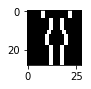

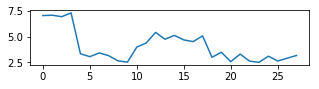

In [198]:
tunnel_dataset = TunnelDataset(csv_file = '/Users/roberto/code/speed-from-image/images/speed_labels.csv',
                               root_dir = '/Users/roberto/code/speed-from-image/images/')
sampe_idx = 0
sample = tunnel_dataset[sampe_idx]

print(sampe_idx, sample['image'].shape, sample['speeds'].shape)

plt.figure(figsize=(1,1))
plt.imshow(sample['image'],cmap='gray', vmin=0, vmax=255)
plt.figure(figsize=(5,1))
plt.plot(sample['speeds'])
plt.show()

In [199]:
full_dataset = TunnelDataset(csv_file = '/Users/roberto/code/speed-from-image/images/speed_labels.csv',
                                    root_dir = '/Users/roberto/code/speed-from-image/images/',
                                    transform=transforms.Compose([ToTensor()]))
train_ratio = 0.7
validate_ratio = 0.1
train_size = int(train_ratio * len(full_dataset))
val_size = int(validate_ratio * len(full_dataset))
test_size = len(full_dataset) - (train_size + val_size)
train_dataset,val_dataset,test_dataset = torch.utils.data.random_split(full_dataset,[train_size,val_size,test_size])
print('Training set size:',len(train_dataset))
print('Validation set size:',len(val_dataset))
print('Test set size:',len(test_dataset))

sample = train_dataset[0]
print(0, sample['image'].size(), sample['speeds'].size())

Training set size: 350
Validation set size: 50
Test set size: 100
0 torch.Size([28, 28]) torch.Size([28])


In [200]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square convolution
        # kernel
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.conv2 = nn.Conv2d(6, 16, 3)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(400, 120)  # 6*6 from image dimension
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 28)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x.float())), (2, 2))
        # If the size is a square you can only specify a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=28, bias=True)
)


[1,    22] loss: 156.201
[2,    22] loss: 50.767
[3,    22] loss: 39.172
[4,    22] loss: 32.032
[5,    22] loss: 26.673
[6,    22] loss: 22.333
[7,    22] loss: 19.365
[8,    22] loss: 16.819
[9,    22] loss: 15.461
[10,    22] loss: 14.254
[11,    22] loss: 13.356
[12,    22] loss: 12.568
[13,    22] loss: 11.953
[14,    22] loss: 11.347
[15,    22] loss: 10.561
[16,    22] loss: 10.136
[17,    22] loss: 9.548
[18,    22] loss: 9.359
[19,    22] loss: 9.292
[20,    22] loss: 8.870
[21,    22] loss: 8.492
[22,    22] loss: 8.196
[23,    22] loss: 8.092
[24,    22] loss: 8.022
[25,    22] loss: 7.644
[26,    22] loss: 7.543
[27,    22] loss: 7.362
[28,    22] loss: 6.958
[29,    22] loss: 7.026
[30,    22] loss: 6.682
[31,    22] loss: 6.538
[32,    22] loss: 6.469
[33,    22] loss: 6.263
[34,    22] loss: 5.998
[35,    22] loss: 5.809
[36,    22] loss: 5.565
[37,    22] loss: 5.487
[38,    22] loss: 5.427
[39,    22] loss: 5.267
[40,    22] loss: 5.132
[41,    22] loss: 5.104
[42,    

Text(0.5,1,'Loss after each epoch')

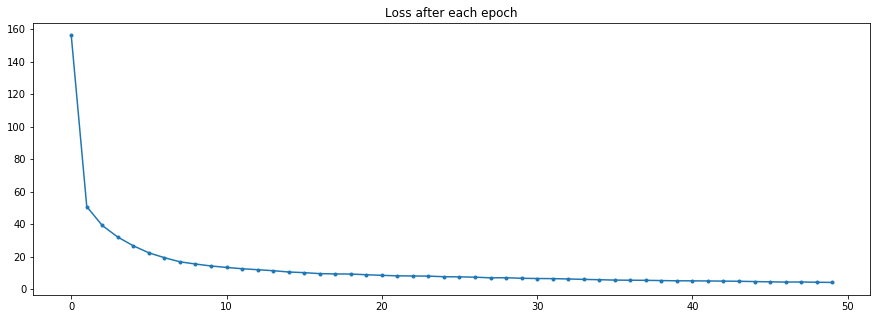

In [209]:
train_loader = DataLoader(train_dataset, batch_size=16,
                        shuffle=True, num_workers=1)

import torch.optim as optim
import torch
torch.manual_seed(0)
learning_rate = 1e-3
net = Net()
criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

losses_over_epochs = []
for epoch in range(50):  # loop over the dataset multiple times
    running_loss = 0.0
    for batch_idx, sample_batched in enumerate(train_loader):
        inputs = sample_batched['image'].unsqueeze_(1) #batch_size, channels, H, W
        labels = sample_batched['speeds'].to(torch.float32)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if(batch_idx == len(train_loader)-1):
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, batch_idx + 1, running_loss / 1))
            losses_over_epochs.append(running_loss)
            running_loss = 0.0
#             print(inputs.shape)
#             print(labels.shape)

print('Finished Training')
plt.figure(figsize=(15,5))
plt.plot(losses_over_epochs,'.-')
plt.title("Loss after each epoch")

torch.Size([1, 1, 28, 28])
[[3.4665048 3.7110598 3.1698334 3.641888  2.8043184 2.156417  1.7554698
  2.0234983 2.063574  1.8390077 1.6525145 2.087706  1.9085057 2.006396
  2.4860778 4.4023833 4.699762  5.1693163 5.0602965 5.1787605 4.2985315
  4.698459  5.5314364 5.590031  4.7152715 4.7975225 4.202419  4.112674 ]]


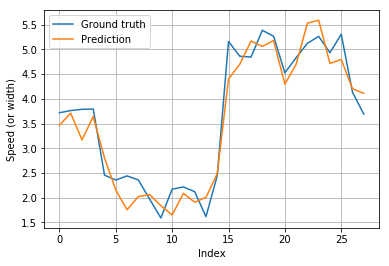

In [210]:
img_idx = 0
img = train_loader.dataset[img_idx]['image'].unsqueeze_(0).unsqueeze_(0)
print(img.shape)
speed_labels = train_loader.dataset[img_idx]['speeds']

speed_estimate = net(img).detach().numpy()
plt.plot(speed_labels,label='Ground truth')
plt.plot(speed_estimate[0],label='Prediction')
plt.xlabel('Index')
plt.ylabel('Speed (or width)')
plt.legend()
plt.grid()
print(speed_estimate)

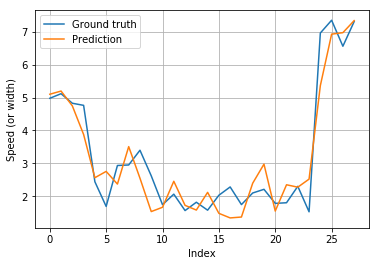

In [211]:
val_loader = DataLoader(val_dataset, batch_size=1,
                        shuffle=False, num_workers=1)
for i in range(1):
    img_idx = i
    img = val_loader.dataset[img_idx]['image'].unsqueeze_(0).unsqueeze_(0)
#     print(img.shape)
    speed_labels = val_loader.dataset[img_idx]['speeds']

    speed_estimate = net(img).detach().numpy()
    plt.figure()
    plt.plot(speed_labels,label='Ground truth')
    plt.plot(speed_estimate[0],label='Prediction')
    plt.xlabel('Index')
    plt.ylabel('Speed (or width)')
    plt.legend()
    plt.grid()
#     print(speed_estimate)

In [222]:
print("Average RMSE (over entire subset)")
print("Validation set:")
cumulative_RMSE = 0
for i in range(len(val_loader)):
    img = val_loader.dataset[i]['image'].unsqueeze_(0).unsqueeze_(0)
    speed_labels = val_loader.dataset[i]['speeds'].numpy()
    speed_estimate = net(img).detach().numpy()
    RMSE = np.sqrt(np.mean(np.square(speed_labels - speed_estimate)/len(speed_labels)))
    cumulative_RMSE += RMSE
print(cumulative_RMSE/len(val_loader))

cumulative_RMSE = 0
# Not sure if this is the best way to do this, but otherwise the batch size will be what it was in training
# and I don't know what that causes this loop to do.
train_loader = DataLoader(train_dataset, batch_size=1,
                        shuffle=False, num_workers=1)
print("Training set:")
for i in range(len(train_loader)):
    img = train_loader.dataset[i]['image'].unsqueeze_(0).unsqueeze_(0)
    speed_labels = train_loader.dataset[i]['speeds'].numpy()
    speed_estimate = net(img).detach().numpy()
    RMSE = np.sqrt(np.mean(np.square(speed_labels - speed_estimate)/len(speed_labels)))
    cumulative_RMSE += RMSE
#     print(RMSE)
print(cumulative_RMSE/len(train_loader))

Average RMSE (over entire subset)
Validation set:
0.1548490732559263
Training set:
0.07736421542129429


In [223]:
train_loader = DataLoader(train_dataset, batch_size=1,
                        shuffle=True, num_workers=1)
len(train_loader)

350

In [228]:
val_loader = DataLoader(val_dataset, batch_size=1,
                        shuffle=False, num_workers=1)
len(val_loader)

50

In [229]:
len(val_dataset)

50